In [1]:
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

#Store Data Variables
import json
with open('feature_data.json', 'r') as f:
 features = json.load(f)

from scipy.io import loadmat
train_idxs = loadmat('cuhk03_new_protocol_config_labeled.mat')['train_idx'].flatten()
query_idxs = loadmat('cuhk03_new_protocol_config_labeled.mat')['query_idx'].flatten()
labels = loadmat('cuhk03_new_protocol_config_labeled.mat')['labels'].flatten()
gallery_idxs = loadmat('cuhk03_new_protocol_config_labeled.mat')['gallery_idx'].flatten()
filelist = loadmat('cuhk03_new_protocol_config_labeled.mat')['filelist'].flatten()
camId = loadmat('cuhk03_new_protocol_config_labeled.mat')['camId'].flatten()

In [2]:
train_idxs

array([    1,     2,     3, ..., 14094, 14095, 14096], dtype=uint16)

In [3]:
query_idxs

array([   22,    27,    49, ..., 14043, 14059, 14063], dtype=uint16)

In [4]:
labels

array([   1,    1,    1, ..., 1467, 1467, 1467], dtype=uint16)

In [5]:
gallery_idxs

array([   21,    23,    24, ..., 14062, 14064, 14065], dtype=uint16)

In [6]:
filelist

array([array(['1_001_1_01.png'], dtype='<U14'),
       array(['1_001_1_02.png'], dtype='<U14'),
       array(['1_001_1_03.png'], dtype='<U14'), ...,
       array(['5_049_2_08.png'], dtype='<U14'),
       array(['5_049_2_09.png'], dtype='<U14'),
       array(['5_049_2_10.png'], dtype='<U14')], dtype=object)

In [7]:
camId

array([1, 1, 1, ..., 2, 2, 2], dtype=uint8)

In [8]:
#grid searc cv against k, distance metric and transformation/normalization - use only query and gallery for this part 

In [9]:

X = np.array(features)
y = np.array(labels)
filelist = np.array(filelist)
camId = np.array(camId)



In [10]:
mask_train = np.array(train_idxs).ravel()
mask_query = np.array(query_idxs).ravel()
mask_gallery = np.array(gallery_idxs).ravel()

mask_train = np.subtract(mask_train, 1)
mask_query = np.subtract(mask_query, 1)
mask_gallery = np.subtract(mask_gallery, 1)


X_train, X_query, X_gallery = X[mask_train, :], X[mask_query, :], X[mask_gallery, :]
y_train, y_query, y_gallery = y[mask_train], y[mask_query], y[mask_gallery]
filelist_train, filelist_query, filelist_gallery = filelist[mask_train], filelist[mask_query], filelist[mask_gallery]
camId_train, camId_query, camId_gallery = camId[mask_train], camId[mask_query], camId[mask_gallery]


In [11]:
def get_acc_score(y_valid, y_q, tot_label_occur):
    recall = 0
    true_positives = 0
    
    k = 0
    
    max_rank = 30
    
    rank_A = np.zeros(max_rank)
    AP_arr = np.zeros(11)
    
    while (recall < 1) or (k < max_rank):
        
        if (y_valid[k] == y_q):
            
            true_positives = true_positives + 1
            recall = true_positives/tot_label_occur
            precision = true_positives/(k+1)
            
            AP_arr[round((recall-0.05)*10)] = precision
            
            for n in range (k, max_rank):
                rank_A[n] = 1
            
        k = k+1
        
    max_precision = 0
    for i in range(10, -1, -1):
        max_precision = max(max_precision, AP_arr[i])
        AP_arr[i] = max_precision
    
    AP_ = AP_arr.sum()/11
    
    return AP_, rank_A

In [12]:
from scipy.spatial import distance

def evaluate_metric(X_query, camId_query, y_query, X_gallery, camId_gallery, y_gallery, metric = 'euclidian', parameters = None):

    rank_accuracies = []
    AP = []

    # Break condition for testing
    #q = 0

    for query, camId_q, y_q in zip(X_query, camId_query, y_query):
        q_g_dists = []
        y_valid = []
        for gallery, camId_g, y_g  in zip(X_gallery, camId_gallery, y_gallery):
            if ((camId_q == camId_g) and (y_q == y_g)):
                continue
            else:
                if metric == 'euclidian':
                    dist = distance.euclidean(query, gallery)
                elif metric == 'sqeuclidean':
                    dist = distance.sqeuclidean(query, gallery)
                elif metric == 'seuclidean':
                    dist = distance.seuclidean(query, gallery)
                elif metric == 'minkowski':
                    dist = distance.minkowski(query, gallery, parameters)
                elif metric == 'chebyshev':
                    dist = distance.chebyshev(query, gallery)
                elif metric == 'braycurtis':
                    dist = distance.braycurtis(query, gallery)
                elif metric == 'canberra':
                    dist = distance.canberra(query, gallery)
                elif metric == 'cosine':
                    dist = distance.cosine(query, gallery)
                elif metric == 'correlation':
                    dist = distance.correlation(query, gallery)
                elif metric == 'mahalanobis':
                    dist = distance.mahalanobis(query, gallery, parameters)
                else:
                    raise NameError('Specified metric not supported')           
                q_g_dists.append(dist)
                y_valid.append(y_g)
    
        tot_label_occur = y_valid.count(y_q)
    
        q_g_dists = np.array(q_g_dists)
        y_valid = np.array(y_valid)
    
        _indexes = np.argsort(q_g_dists)
    
        # Sorted distances and labels
        q_g_dists, y_valid = q_g_dists[_indexes], y_valid[_indexes]
    
        AP_, rank_A = get_acc_score(y_valid, y_q, tot_label_occur)
    
        AP.append(AP_)
        
        rank_accuracies.append(rank_A)
    
        #if q  > 20:
        #    break
        #q = q+1

    rank_accuracies = np.array(rank_accuracies)

    total = rank_accuracies.shape[0]
    rank_accuracies = rank_accuracies.sum(axis = 0)
    rank_accuracies = np.divide(rank_accuracies, total)

    i = 0
    print ('Accuracies by Rank:')
    while i < rank_accuracies.shape[0]:
        print('Rank ', i+1, ' = %.2f%%' % (rank_accuracies[i] * 100), '\t',
              'Rank ', i+2, ' = %.2f%%' % (rank_accuracies[i+1] * 100), '\t',
              'Rank ', i+3, ' = %.2f%%' % (rank_accuracies[i+2] * 100), '\t',
              'Rank ', i+4, ' = %.2f%%' % (rank_accuracies[i+3] * 100), '\t',
              'Rank ', i+5, ' = %.2f%%' % (rank_accuracies[i+4] * 100))
        i = i+5

    AP = np.array(AP)

    mAP = AP.sum()/AP.shape[0]
    print('mAP = %.2f%%' % (mAP * 100))
    
    return rank_accuracies, mAP

    
        
    

In [13]:
# Baseline Euclidian

import time

start = time.time()

rank_accuracies, mAP = evaluate_metric(X_query, camId_query, y_query,
                                       X_gallery, camId_gallery, y_gallery,
                                       metric = 'euclidian',
                                       parameters = None)

end = time.time()
time_knn_base = end-start


Accuracies by Rank:
Rank  1  = 47.00% 	 Rank  2  = 54.57% 	 Rank  3  = 59.64% 	 Rank  4  = 63.93% 	 Rank  5  = 66.86%
Rank  6  = 69.29% 	 Rank  7  = 71.14% 	 Rank  8  = 72.36% 	 Rank  9  = 73.71% 	 Rank  10  = 74.93%
Rank  11  = 75.86% 	 Rank  12  = 76.79% 	 Rank  13  = 77.71% 	 Rank  14  = 78.50% 	 Rank  15  = 79.07%
Rank  16  = 79.86% 	 Rank  17  = 80.64% 	 Rank  18  = 81.57% 	 Rank  19  = 82.29% 	 Rank  20  = 83.21%
Rank  21  = 83.50% 	 Rank  22  = 83.71% 	 Rank  23  = 84.00% 	 Rank  24  = 84.29% 	 Rank  25  = 84.79%
Rank  26  = 85.29% 	 Rank  27  = 85.64% 	 Rank  28  = 85.93% 	 Rank  29  = 86.07% 	 Rank  30  = 86.36%
mAP = 46.57%


In [14]:
from scipy.spatial import distance
from sklearn.cluster import KMeans

def evaluate_metric_kmeans(X_query, camId_query, y_query, X_gallery, camId_gallery, y_gallery, metric = 'euclidian', parameters = None):

    rank_accuracies = []
    AP = []

    # Break condition for testing
    #q = 0
    
    max_rank = 30
    
    kmeans = KMeans(n_clusters=parameters, random_state=0)
    cntr_labels = kmeans.fit_predict(X_gallery)
    centers = kmeans.cluster_centers_

    for query, camId_q, y_q in zip(X_query, camId_query, y_query):
        q_g_dists = []
        y_valid = []
        q_center_dists = []
        c_dist_labels = []
        for i, center in enumerate(centers):
            dist = distance.euclidean(query, center)
            q_center_dists.append(dist)
            c_dist_labels.append(i)
        
        q_center_dists = np.array(q_center_dists)
        c_dist_labels = np.array(c_dist_labels)
    
        _indexes = np.argsort(q_center_dists)
    
        # Sorted distances and labels
        q_center_dists, c_dist_labels = q_center_dists[_indexes], c_dist_labels[_indexes]
        
        k = 0
        center_index = 0
        
        while k < max_rank:

            for gallery, cntr_label, camId_g, y_g  in zip(X_gallery, cntr_labels, camId_gallery, y_gallery):
                if ((camId_q == camId_g) and (y_q == y_g)):
                    continue
                elif cntr_label == c_dist_labels[center_index]:
                    if metric == 'euclidian':
                        dist = distance.euclidean(query, gallery)
                    else:
                        raise NameError('Specified metric not supported')           
                    q_g_dists.append(dist)
                    y_valid.append(y_g)
                    k = k+1
            
            center_index = center_index +1
    
        tot_label_occur = y_valid.count(y_q)
    
        q_g_dists = np.array(q_g_dists)
        y_valid = np.array(y_valid)
    
        _indexes = np.argsort(q_g_dists)
    
        # Sorted distances and labels
        q_g_dists, y_valid = q_g_dists[_indexes], y_valid[_indexes]
    
        if tot_label_occur != 0:
    
            AP_, rank_A = get_acc_score(y_valid, y_q, tot_label_occur)

            AP.append(AP_)

            rank_accuracies.append(rank_A)
    
        #if q  > 5:
        #    break
        #q = q+1

    rank_accuracies = np.array(rank_accuracies)

    total = rank_accuracies.shape[0]
    rank_accuracies = rank_accuracies.sum(axis = 0)
    rank_accuracies = np.divide(rank_accuracies, total)

    i = 0
    print ('Accuracies by Rank:')
    while i < rank_accuracies.shape[0]:
        print('Rank ', i+1, ' = %.2f%%' % (rank_accuracies[i] * 100), '\t',
              'Rank ', i+2, ' = %.2f%%' % (rank_accuracies[i+1] * 100), '\t',
              'Rank ', i+3, ' = %.2f%%' % (rank_accuracies[i+2] * 100), '\t',
              'Rank ', i+4, ' = %.2f%%' % (rank_accuracies[i+3] * 100), '\t',
              'Rank ', i+5, ' = %.2f%%' % (rank_accuracies[i+4] * 100))
        i = i+5

    AP = np.array(AP)

    mAP = AP.sum()/AP.shape[0]
    print('mAP = %.2f%%' % (mAP * 100))
    
    return rank_accuracies, mAP

    
        
    

In [17]:
# Baseline Euclidian with KMeans

import time

num_clusters = 1

rank_accuracies_l = []
mAP_l = []
num_clusters_l = []
time_pre_l = []

while num_clusters < 2049:
    print ('For num_clusters = ', num_clusters)
    start = time.time()
    rank_accuracies, mAP = evaluate_metric_kmeans(X_query, camId_query, y_query,
                                                  X_gallery, camId_gallery, y_gallery,
                                                  metric ='euclidian',
                                                  parameters = num_clusters)
    
    end = time.time()
    time_pre_l.append(end-start)
    rank_accuracies_l.append(rank_accuracies)
    num_clusters_l.append(num_clusters)
    mAP_l.append(mAP)
    
    num_clusters = num_clusters*2



For num_clusters =  1
Accuracies by Rank:
Rank  1  = 47.00% 	 Rank  2  = 54.57% 	 Rank  3  = 59.64% 	 Rank  4  = 63.93% 	 Rank  5  = 66.86%
Rank  6  = 69.29% 	 Rank  7  = 71.14% 	 Rank  8  = 72.36% 	 Rank  9  = 73.71% 	 Rank  10  = 74.93%
Rank  11  = 75.86% 	 Rank  12  = 76.79% 	 Rank  13  = 77.71% 	 Rank  14  = 78.50% 	 Rank  15  = 79.07%
Rank  16  = 79.86% 	 Rank  17  = 80.64% 	 Rank  18  = 81.57% 	 Rank  19  = 82.29% 	 Rank  20  = 83.21%
Rank  21  = 83.50% 	 Rank  22  = 83.71% 	 Rank  23  = 84.00% 	 Rank  24  = 84.29% 	 Rank  25  = 84.79%
Rank  26  = 85.29% 	 Rank  27  = 85.64% 	 Rank  28  = 85.93% 	 Rank  29  = 86.07% 	 Rank  30  = 86.36%
mAP = 46.57%
For num_clusters =  2
Accuracies by Rank:
Rank  1  = 48.49% 	 Rank  2  = 56.33% 	 Rank  3  = 61.31% 	 Rank  4  = 65.76% 	 Rank  5  = 68.85%
Rank  6  = 71.57% 	 Rank  7  = 73.30% 	 Rank  8  = 74.36% 	 Rank  9  = 75.72% 	 Rank  10  = 76.92%
Rank  11  = 77.83% 	 Rank  12  = 78.96% 	 Rank  13  = 79.56% 	 Rank  14  = 80.39% 	 Rank  15  = 8

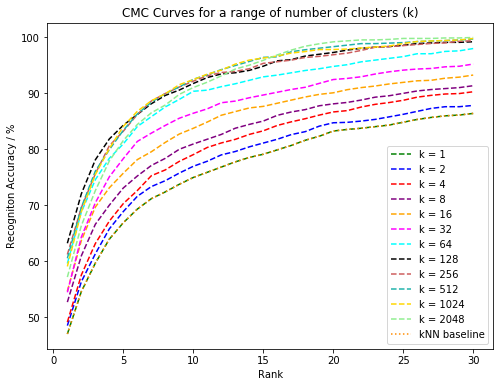

In [21]:
plt.figure(figsize=(8.0, 6.0))
color_list = ['green', 'blue', 'red', 'purple', 'orange', 'magenta', 'cyan', 'black', 'indianred', 'lightseagreen', 'gold', 'lightgreen']
for i in range(len(num_clusters_l)):
    plt.plot(np.arange(1, 31), 100*rank_accuracies_l[i], color=color_list[i], linestyle='dashed', label='k = '+str(num_clusters_l[i]))
plt.plot(np.arange(1, 31), 100*rank_accuracies_l[0], color='darkorange', linestyle=':', label='kNN baseline')
plt.title('CMC Curves for a range of number of clusters (k)')
plt.xlabel('Rank')
plt.ylabel('Recogniton Accuracy / %')
plt.legend(loc='best')

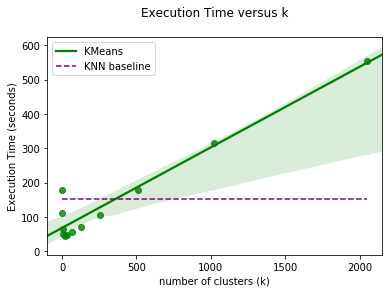

In [25]:
import seaborn as sns

Ms = np.arange(1,416)

plt.figure()
# plt.plot(Ms, train_dur)
sns.regplot(x=np.array(num_clusters_l), y=np.array(time_pre_l), color = 'green')
# plt.plot(Ms, test_dur)
#sns.regplot(x=np.array(num_clusters_l), y=np.full(len(time_l), time_knn_base), color = 'purple')
plt.plot(np.array(num_clusters_l), np.full(len(time_pre_l), time_knn_base), color='purple', linestyle='dashed')
plt.title('Execution Time versus k\n')
plt.xlabel('number of clusters (k)')
plt.ylabel('Execution Time (seconds)')
plt.legend(['kMeans (Precomputed)', 'kNN baseline'])

In [14]:
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

def evaluate_metric_kmeans_long(X_query, camId_query, y_query, X_gallery, camId_gallery, y_gallery, metric = 'euclidian', parameters = None):

    rank_accuracies = []
    AP = []

    # Break condition for testing
    #q = 0
    
    max_rank = 30

    for i, (query, camId_q, y_q) in enumerate(zip(X_query, camId_query, y_query)):
        q_g_dists = []
        y_valid = []
        q_center_dists = []
        c_dist_labels = []
        
        X_gallery_red = []
        y_gallery_red = []
        
        
        for gallery, camId_g, y_g  in zip(X_gallery, camId_gallery, y_gallery):
            if ((camId_q == camId_g) and (y_q == y_g)):
                continue
            else:
                X_gallery_red.append(gallery)
                y_gallery_red.append(y_g)
                

        X_gallery_red = np.array(X_gallery_red)
        y_gallery_red = np.array(y_gallery_red)
        
        kmeans = MiniBatchKMeans(n_clusters=parameters, random_state=0)
        cntr_labels = kmeans.fit_predict(X_gallery_red)
        centers = kmeans.cluster_centers_
        
        for i, center in enumerate(centers):
            dist = distance.euclidean(query, center)
            q_center_dists.append(dist)
            c_dist_labels.append(i)
        
        q_center_dists = np.array(q_center_dists)
        c_dist_labels = np.array(c_dist_labels)
    
        _indexes = np.argsort(q_center_dists)
    
        # Sorted distances and labels
        q_center_dists, c_dist_labels = q_center_dists[_indexes], c_dist_labels[_indexes]
        
        k = 0
        center_index = 0
        
        while k < max_rank:

            for gallery, cntr_label, y_g  in zip(X_gallery_red, cntr_labels, y_gallery_red):
                if cntr_label == c_dist_labels[center_index]:
                    if metric == 'euclidian':
                        dist = distance.euclidean(query, gallery)
                    else:
                        raise NameError('Specified metric not supported')           
                    q_g_dists.append(dist)
                    y_valid.append(y_g)
                    k = k+1
            
            center_index = center_index +1
    
        tot_label_occur = y_valid.count(y_q)
    
        q_g_dists = np.array(q_g_dists)
        y_valid = np.array(y_valid)
    
        _indexes = np.argsort(q_g_dists)
    
        # Sorted distances and labels
        q_g_dists, y_valid = q_g_dists[_indexes], y_valid[_indexes]
    
        if tot_label_occur != 0:
    
            AP_, rank_A = get_acc_score(y_valid, y_q, tot_label_occur)

            AP.append(AP_)

            rank_accuracies.append(rank_A)
    
        #if q  > 20:
        #    break
        #q = q+1

    rank_accuracies = np.array(rank_accuracies)

    total = rank_accuracies.shape[0]
    rank_accuracies = rank_accuracies.sum(axis = 0)
    rank_accuracies = np.divide(rank_accuracies, total)

    i = 0
    print ('Accuracies by Rank:')
    while i < rank_accuracies.shape[0]:
        print('Rank ', i+1, ' = %.2f%%' % (rank_accuracies[i] * 100), '\t',
              'Rank ', i+2, ' = %.2f%%' % (rank_accuracies[i+1] * 100), '\t',
              'Rank ', i+3, ' = %.2f%%' % (rank_accuracies[i+2] * 100), '\t',
              'Rank ', i+4, ' = %.2f%%' % (rank_accuracies[i+3] * 100), '\t',
              'Rank ', i+5, ' = %.2f%%' % (rank_accuracies[i+4] * 100))
        i = i+5

    AP = np.array(AP)

    mAP = AP.sum()/AP.shape[0]
    print('mAP = %.2f%%' % (mAP * 100))
    
    return rank_accuracies, mAP

    
        
    

In [15]:


# Baseline Euclidian with KMeans

import time

num_clusters = 1

rank_accuracies_l = []
mAP_l = []
num_clusters_l = []
time_post_l = []

while num_clusters < 2049:
    print ('For num_clusters = ', num_clusters)
    start = time.time()
    rank_accuracies, mAP = evaluate_metric_kmeans_long(X_query, camId_query, y_query,
                                                       X_gallery, camId_gallery, y_gallery,
                                                       metric ='euclidian',
                                                       parameters = num_clusters)
    
    end = time.time()
    time_post_l.append(end-start)
    rank_accuracies_l.append(rank_accuracies)
    num_clusters_l.append(num_clusters)
    mAP_l.append(mAP)
    
    num_clusters = num_clusters*2






For num_clusters =  1
Accuracies by Rank:
Rank  1  = 47.00% 	 Rank  2  = 54.57% 	 Rank  3  = 59.64% 	 Rank  4  = 63.93% 	 Rank  5  = 66.86%
Rank  6  = 69.29% 	 Rank  7  = 71.14% 	 Rank  8  = 72.36% 	 Rank  9  = 73.71% 	 Rank  10  = 74.93%
Rank  11  = 75.86% 	 Rank  12  = 76.79% 	 Rank  13  = 77.71% 	 Rank  14  = 78.50% 	 Rank  15  = 79.07%
Rank  16  = 79.86% 	 Rank  17  = 80.64% 	 Rank  18  = 81.57% 	 Rank  19  = 82.29% 	 Rank  20  = 83.21%
Rank  21  = 83.50% 	 Rank  22  = 83.71% 	 Rank  23  = 84.00% 	 Rank  24  = 84.29% 	 Rank  25  = 84.79%
Rank  26  = 85.29% 	 Rank  27  = 85.64% 	 Rank  28  = 85.93% 	 Rank  29  = 86.07% 	 Rank  30  = 86.36%
mAP = 46.57%
For num_clusters =  2
Accuracies by Rank:
Rank  1  = 48.99% 	 Rank  2  = 56.51% 	 Rank  3  = 61.24% 	 Rank  4  = 65.74% 	 Rank  5  = 69.30%
Rank  6  = 72.09% 	 Rank  7  = 73.72% 	 Rank  8  = 74.65% 	 Rank  9  = 76.51% 	 Rank  10  = 77.67%
Rank  11  = 78.14% 	 Rank  12  = 79.07% 	 Rank  13  = 79.61% 	 Rank  14  = 80.39% 	 Rank  15  = 8

KeyboardInterrupt: 

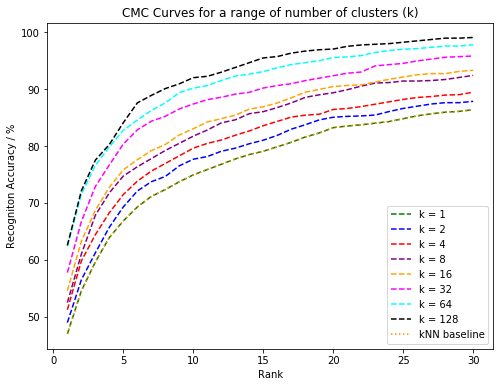

In [16]:
plt.figure(figsize=(8.0, 6.0))
color_list = ['green', 'blue', 'red', 'purple', 'orange', 'magenta', 'cyan', 'black', 'indianred', 'lightseagreen', 'gold', 'lightgreen']
for i in range(len(num_clusters_l)):
    plt.plot(np.arange(1, 31), 100*rank_accuracies_l[i], color=color_list[i], linestyle='dashed', label='k = '+str(num_clusters_l[i]))
plt.plot(np.arange(1, 31), 100*rank_accuracies_l[0], color='darkorange', linestyle=':', label='kNN baseline')
plt.title('CMC Curves for a range of number of clusters (k)')
plt.xlabel('Rank')
plt.ylabel('Recogniton Accuracy / %')
plt.legend(loc='best')

In [17]:
print(time_post_l)
rank_accuracies_l_post = rank_accuracies_l

[325.62104511260986, 272.87021803855896, 320.33332800865173, 353.90095806121826, 520.8172748088837, 835.8771948814392, 1267.1173560619354, 2046.8742408752441]


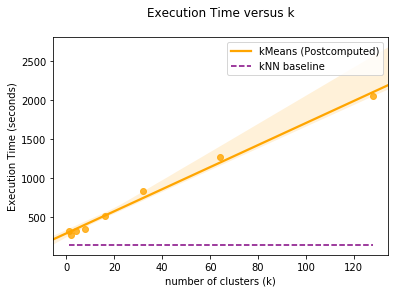

In [20]:
import seaborn as sns

Ms = np.arange(1,416)

plt.figure()
# plt.plot(Ms, train_dur)
#sns.regplot(x=np.array(num_clusters_l), y=np.array(time_pre_l), color = 'green')
sns.regplot(x=np.array(num_clusters_l), y=np.array(time_post_l), color = 'orange')
# plt.plot(Ms, test_dur)
#sns.regplot(x=np.array(num_clusters_l), y=np.full(len(time_l), time_knn_base), color = 'purple')
plt.plot(np.array(num_clusters_l), np.full(len(time_post_l), time_knn_base), color='purple', linestyle='dashed')
plt.title('Execution Time versus k\n')
plt.xlabel('number of clusters (k)')
plt.ylabel('Execution Time (seconds)')
plt.legend(['kMeans (Postcomputed)', 'kNN baseline'])

In [22]:
time_pre_l = [185, 110, 60, 50, 45, 42, 43, 50, 65, 105, 320, 550]
num_clusters_pre = [1,2,4,8,16,32,64,128,256,512,1024,2048]

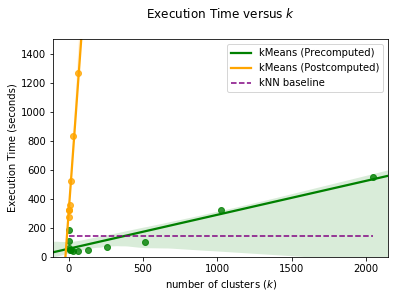

In [32]:
import seaborn as sns

Ms = np.arange(1,416)

plt.figure()
# plt.plot(Ms, train_dur)
sns.regplot(x=np.array(num_clusters_pre), y=np.array(time_pre_l), color = 'green')
sns.regplot(x=np.array(num_clusters_l), y=np.array(time_post_l), color = 'orange')
# plt.plot(Ms, test_dur)
#sns.regplot(x=np.array(num_clusters_l), y=np.full(len(time_l), time_knn_base), color = 'purple')
plt.plot(np.array(num_clusters_pre), np.full(len(time_pre_l), time_knn_base), color='purple', linestyle='dashed')
plt.title('Execution Time versus $k$\n')
plt.xlabel('number of clusters ($k$)')
plt.ylabel('Execution Time (seconds)')
plt.ylim(top = 1500, bottom = 0)
plt.legend(['kMeans (Precomputed)', 'kMeans (Postcomputed)', 'kNN baseline'])

In [40]:
print(y_query.shape)
print (np.unique(y_query).shape)

(1400,)
(700,)
